In [9]:
from scene import Scene
import taichi as ti
from taichi.math import *
import taichi.math as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
import trimesh
import open3d as o3d

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_default_dtype(torch.float16)

%load_ext autoreload
%autoreload 2

matplotlib.use('Qt5Agg')
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\yaozi\AppData\Local\Temp\ipykernel_24060\103515158.py:19: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Qt5Agg')


## 1. Load model (e.g. Stanford bunny)

In [10]:
NUM_X, NUM_Y, NUM_Z = 100, 100, 100
GLASS_IOR = 1.5

def load_and_voxelize_mesh(file_path: str, voxel_size=0.005, num_x=NUM_X, num_y=NUM_Y, num_z=NUM_Z) -> np.ndarray:
    target_mesh = trimesh.load(file_path)
    assert isinstance(target_mesh, trimesh.Trimesh), "Loaded object should be a Trimesh"
    vertices = target_mesh.vertices
    faces = target_mesh.faces

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size)

    filled_voxels = np.zeros((num_x, num_y, num_z), dtype=np.uint8)
    for voxel in voxel_grid.get_voxels():
        voxel_coord = voxel.grid_index
        filled_voxels[voxel_coord[0], voxel_coord[1], voxel_coord[2]] = True
    for y in range(filled_voxels.shape[1]):
        slice_y = filled_voxels[:, y, :]
        filled_slice = ndimage.binary_fill_holes(slice_y)
        filled_voxels[:, y, :] = filled_slice
    print("Voxel shape:", filled_voxels.shape)  
    print("Number of filled voxels:", np.sum(filled_voxels))
    return filled_voxels


file_path = './assets/bun_zipper_res4.ply'
voxel_size = 0.004
bunny_voxels = load_and_voxelize_mesh(file_path, voxel_size)

Voxel shape: (100, 100, 100)
Number of filled voxels: 13849


## 2. Preview scene

In [11]:
@ti.func
def add_ball(r: ti.i32, pad: ti.i32, origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange((-r-pad, r+pad), (-r-pad, r+pad), (-r-pad, r+pad)):
        xyz = ivec3(i, j, k)
        if xyz.dot(xyz) < r**2: 
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func 
def add_bunny(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if bunny_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func
def origin_y(largest: int, r: int):
    return -(largest-r)-1

# Material LAMBERTIAN = 1
# Material LIGHT = 2
@ti.kernel
def initialize_voxels():
    add_ball(largest_r, 1, vec3(-18, origin_y(largest_r, largest_r), 0), RED, 1)
    add_ball(medium_r, 1, vec3(2, origin_y(largest_r, medium_r), 30), BLUE, 1)
    # add_ball(small_r, 1, vec3(17, origin_y(largest_r, small_r), -7), WHITE, 1)
    add_bunny(vec3(3, -18, -6), WHITE, 1)
    
def floor_h(largest: int):
    return -1 / 64 * (largest + 1)  #  +1 to make balls float a bit above the floor

largest_r = 18
medium_r = 12
small_r = 6
floor_height = floor_h(largest_r)
BLACK, WHITE, YELLOW, PINK = vec3(0, 0, 0), vec3(1, 1, 1), vec3(1,1,0), vec3(1,0.5,0.8)
RED, BLUE, PURPLE = vec3(0.9, 0, 0.1), vec3(0, 0.5, 1), vec3(0.2, 0.2, 0.6)

scene = Scene(exposure=1)

bunny_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
bunny_field.from_numpy(bunny_voxels)

scene.set_directional_light((0, 1, 0), 0.2, (1, 1, 1))
scene.set_background_color((1, 1, 1))
scene.set_floor(height=floor_height, color=(1, 1, 1))
initialize_voxels()
scene.finish()

[Taichi] Starting on arch=cuda

Camera:
* Drag with your left mouse button to rotate
* Press W/A/S/D/Q/E to move

[0. 0. 2.] [0. 0. 0.]


## 3. View scene's IOR

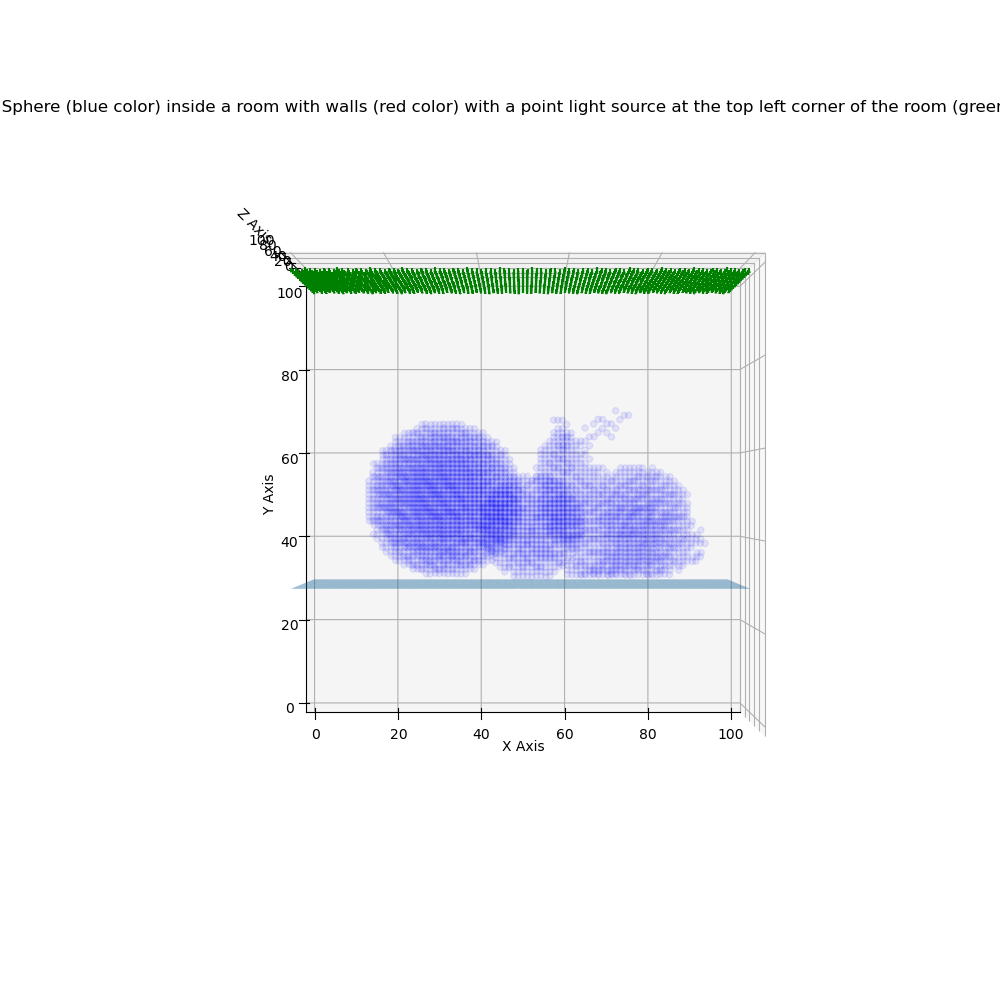

In [12]:
scene_ior = scene.get_ior_grid().to_torch().to(device)
assert isinstance(scene_ior, torch.Tensor) and scene_ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a torch tensor of shape (NUM_X, NUM_Y, NUM_Z)"
initial_wavefront_pos = torch.tensor([(x, NUM_Y-1, z) for x in range(NUM_X) for z in range(NUM_Z)], dtype=torch.float16, device=device)
initial_wavefront_dir = torch.tensor([(0, -1, 0) for _ in range(NUM_X * NUM_Z)], dtype=torch.float16, device=device)

def show_ior_field(ior_field: torch.Tensor, initial_wavefront_positions: torch.Tensor, initial_wavefront_directions: torch.Tensor):    
    plt.close("all") # clear previous plot

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, NUM_X)
    ax.set_ylim(0, NUM_Y)
    ax.set_zlim(0, NUM_Z)
    initial_pos_np = initial_wavefront_positions.cpu().numpy()
    initial_dir_np = initial_wavefront_directions.cpu().numpy()

    # Initial wavefront positions
    subsample_indices = np.arange(0, len(initial_pos_np), 7)
    ax.quiver(initial_pos_np[subsample_indices, 0], initial_pos_np[subsample_indices, 1], initial_pos_np[subsample_indices, 2],
                initial_dir_np[subsample_indices, 0], initial_dir_np[subsample_indices, 1], initial_dir_np[subsample_indices, 2],
                color='green', length=1)
    

    # Regular sampling for the sphere
    x_points_sphere, y_points_sphere, z_points_sphere = torch.where(ior_field.cpu() == GLASS_IOR)
    subsample_step_sphere = max(1, len(x_points_sphere) // 4000)  # Adjust the number to control the number of points
    subsample_indices_sphere = np.arange(0, len(x_points_sphere), subsample_step_sphere)
    ax.scatter(x_points_sphere[subsample_indices_sphere], y_points_sphere[subsample_indices_sphere], z_points_sphere[subsample_indices_sphere], color='blue', alpha=0.08)
    ax.set_title("Glass Sphere (blue color) inside a room with walls (red color) with a point light source at the top left corner of the room (green arrows)")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.view_init(elev=90, azim=-90)

    xx, zz = np.meshgrid(np.arange(NUM_X), np.arange(NUM_Z))
    yy = np.ones_like(xx) * (-floor_height) * NUM_Y
    ax.plot_surface(xx, yy, zz, alpha=0.5)
    plt.show()

show_ior_field(scene_ior, initial_wavefront_pos, initial_wavefront_dir)

## 4. Light simulator (Implemented in PyTorch)

In [13]:
@torch.jit.script
def compute_3d_gradients(ior_field: torch.Tensor, device: torch.device) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    grad_x, grad_y, grad_z = torch.gradient(ior_field)
    return grad_x.to(device), grad_y.to(device), grad_z.to(device)

scene_ior_gradients = compute_3d_gradients(scene_ior, device)

In [14]:
@torch.jit.script
def update_wavefront(pos: torch.Tensor, dir: torch.Tensor, within_mask: torch.Tensor, grad_xyz: tuple[torch.Tensor, torch.Tensor, torch.Tensor], IOR: torch.Tensor, delta_t: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    indices = pos.int()
    # Obtain the refractive index at the current position
    n = IOR[indices[:, 0].clamp(0, IOR.shape[0] - 1),
            indices[:, 1].clamp(0, IOR.shape[1] - 1),
            indices[:, 2].clamp(0, IOR.shape[2] - 1)]

    # Calculate the new position and direction of the wavefront
    new_pos = pos + delta_t * dir / (n**2).unsqueeze(1)

    # Create a mask to identify the wavefront positions that are within the boundaries of the IOR field
    new_within_mask = (new_pos[:, 0] >= 0) & (new_pos[:, 0] < IOR.shape[0]) & \
                      (new_pos[:, 1] >= 0) & (new_pos[:, 1] < IOR.shape[1]) & \
                      (new_pos[:, 2] >= 0) & (new_pos[:, 2] < IOR.shape[2]) & \
                      within_mask
    
    # Clamp the indices to ensure they are within the valid range of grad_xyz
    clamped_indices_x = indices[:, 0].clamp(0, grad_xyz[0].shape[0] - 1)
    clamped_indices_y = indices[:, 1].clamp(0, grad_xyz[1].shape[1] - 1)
    clamped_indices_z = indices[:, 2].clamp(0, grad_xyz[2].shape[2] - 1)

    # Update the direction only for the wavefront positions within the IOR boundaries
    new_dir = torch.where(new_within_mask.unsqueeze(1),
                          dir + delta_t * torch.stack([grad_xyz[0][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[1][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[2][clamped_indices_x, clamped_indices_y, clamped_indices_z]], dim=1) / n.unsqueeze(1),
                          dir)

    return new_pos, new_dir, new_within_mask

@torch.jit.script
def simulate_wavefront_propagation(cur_IOR: torch.Tensor, grad_xyz: tuple[torch.Tensor, torch.Tensor, torch.Tensor], 
                                   initial_wavefront_pos: torch.Tensor, initial_wavefront_dir: torch.Tensor, 
                                   device: torch.device, num_steps: int = 100, delta_t: float = 1.0) -> tuple[list[torch.Tensor], list[torch.Tensor]]:
    wavefront_pos_list = [initial_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    cur_mask = torch.ones(initial_wavefront_pos.shape[0], dtype=torch.bool, device=device)
    for _ in range(num_steps):
        new_positions, new_directions, new_mask = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_mask, grad_xyz, cur_IOR, delta_t)
        wavefront_pos_list.append(new_positions)
        wavefront_dir_list.append(new_directions)
        cur_mask = new_mask
    return wavefront_pos_list, wavefront_dir_list

test_num_steps = 150
test_delta_t = 1.0 * NUM_Y / 100
wavefront_positions_list, wavefront_directions_list = simulate_wavefront_propagation(scene_ior, scene_ior_gradients, initial_wavefront_pos, initial_wavefront_dir, device, test_num_steps, test_delta_t)

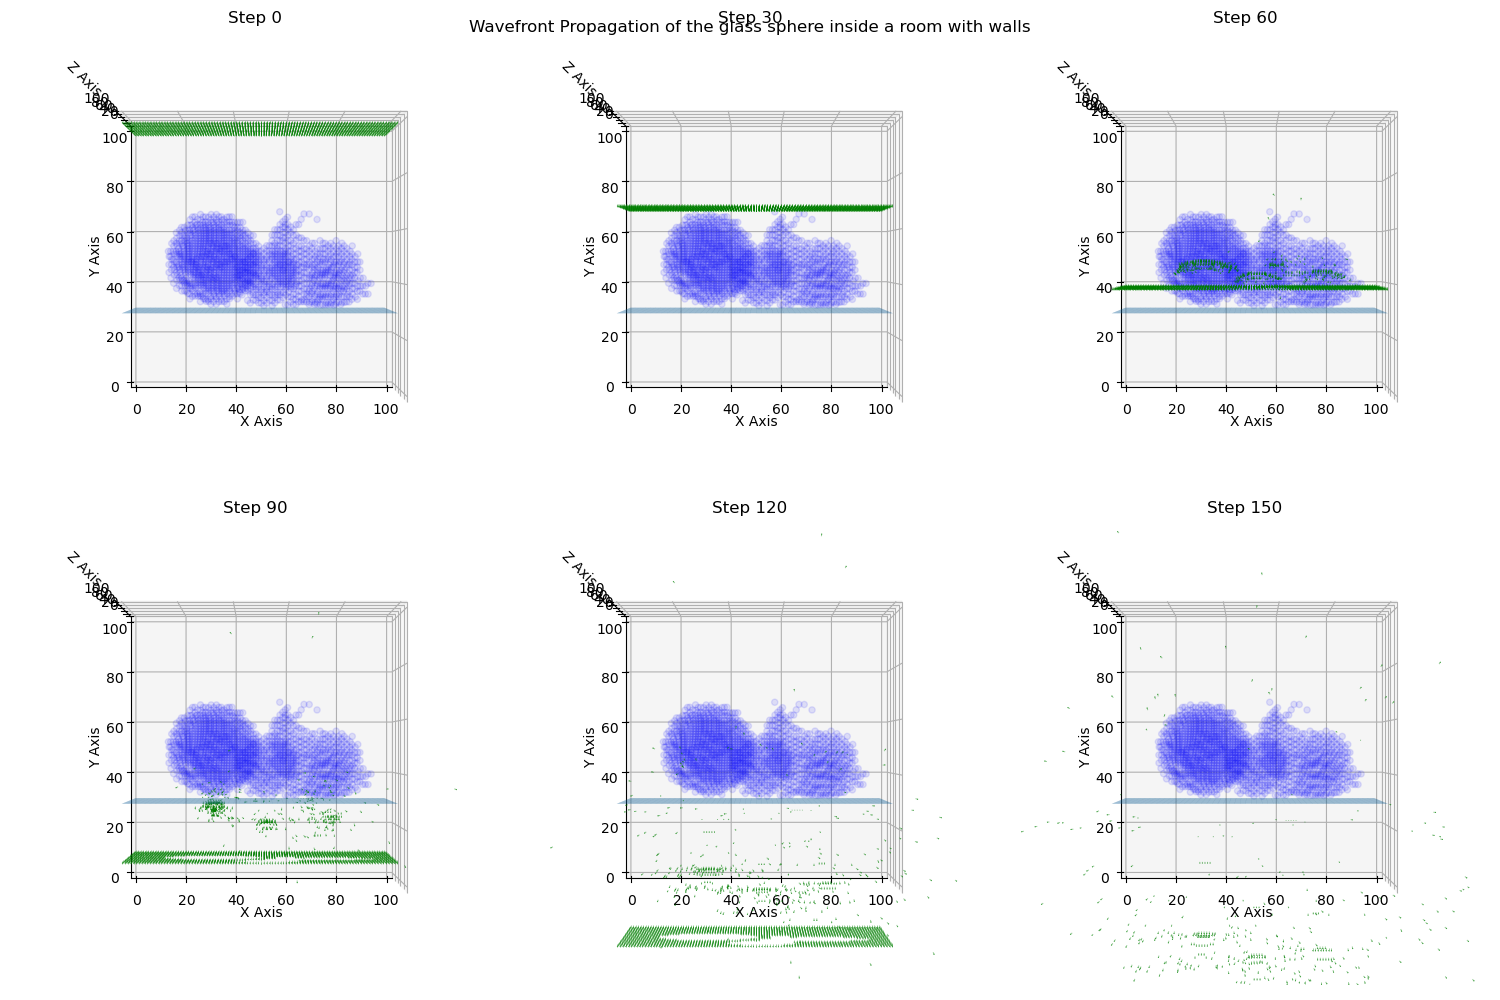

In [17]:
def show_propagation_results(convex_pos_res, convex_dir_res, IOR, num_show_images, fig_name):
    num_cols = min(num_show_images, 3)
    num_rows = (num_show_images + num_cols - 1) // num_cols
    num_steps = len(convex_pos_res) - 1

    show_indices = [i for i in range(0, num_steps+1, max(num_steps // (num_show_images-1), 1))]
    show_indices.append(num_steps)
    if len(show_indices) > num_show_images:
        show_indices = show_indices[:num_show_images]

    fig = plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    
    for i, index in enumerate(show_indices):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, IOR.shape[0])
        ax.set_ylim(0, IOR.shape[1])
        ax.set_zlim(0, IOR.shape[2])
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title(f"Step {index}")
        
        # Visualize 3D IOR field
        IOR_np = IOR.cpu().numpy()
        x_points, y_points, z_points = np.where(IOR_np == GLASS_IOR)
        subsample_step_sphere = max(1, len(x_points) // 1500)  # Adjust the number to control the number of points
        subsample_indices_sphere = np.arange(0, len(x_points), subsample_step_sphere)
        ax.scatter(x_points[subsample_indices_sphere], y_points[subsample_indices_sphere], z_points[subsample_indices_sphere], color='blue', alpha=0.1)

        # Visualize Wavefront
        wavefront_positions = convex_pos_res[index].cpu().numpy()
        wavefront_directions = convex_dir_res[index].cpu().numpy()
        subsample_step_wavefront = max(1, wavefront_positions.shape[0] // 2000)  # Adjust the number to control the number of points
        subsample_indices_wavefront = np.arange(0, wavefront_positions.shape[0], subsample_step_wavefront)
        ax.quiver(wavefront_positions[subsample_indices_wavefront, 0], wavefront_positions[subsample_indices_wavefront, 1], wavefront_positions[subsample_indices_wavefront, 2], 
                  wavefront_directions[subsample_indices_wavefront, 0], wavefront_directions[subsample_indices_wavefront, 1], wavefront_directions[subsample_indices_wavefront, 2],
                  length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.4)
        xx, zz = np.meshgrid(np.arange(NUM_X), np.arange(NUM_Z))
        yy = np.ones_like(xx) * (-floor_height) * NUM_Y
        ax.plot_surface(xx, yy, zz, alpha=0.5)
        ax.view_init(elev=90, azim=-90)
        
    fig.tight_layout()
    fig.suptitle(fig_name)
    plt.show()

num_show_images = 6
show_propagation_results(wavefront_positions_list, wavefront_directions_list, scene_ior, num_show_images, "Wavefront Propagation of the glass sphere inside a room with walls")

### Temp

In [16]:
x = ti.field(float, shape=(3, 3))
a = np.arange(9).reshape(3, 3).astype(np.int32)
x.from_numpy(a)
print(x)
type(x)
arr = x.to_numpy()
print(arr)
type(arr)
field = ti.Vector.field(3, int, shape=(256, 512))
field.shape  # (256, 512)
field.n      # 3

array = field.to_numpy()
array.shape  # (256, 512, 3)
print(type(array))

field.from_numpy(array)  # the input array must in the shape (256, 512, 3)
print(type(field))

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
<class 'numpy.ndarray'>
<class 'taichi.lang.matrix.MatrixField'>


## Render